<a href="https://colab.research.google.com/github/shahp7575/database_proj/blob/master/Stats_Learn_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as sps
import warnings
warnings.filterwarnings('ignore') 

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import  SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

In [5]:
data = load_iris()
X = data.data
y = data.target

In [37]:
data.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [18]:
X.shape, y.shape

((150, 4), (150,))

## Question 1: 

##### Decision Stump + AdaBoost model

In [12]:
dec_stump = DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [21]:
pred = np.mean(cross_validate(dec_stump, X, y, cv=10)['test_score'])

In [23]:
print("Accuracy: ", pred*100)

Accuracy:  66.66666666666667


In [191]:
class Boosting:

    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.train_X = dataset.data
        self.train_y = dataset.target
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.accuracy = []
        self.predictions = None
    
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.train_X
        y = self.train_y

        # Initialize the weights of each sample with wi = 1/N and create a dataframe in which the evaluation is computed
        Evaluation = pd.DataFrame(y.copy(), columns=['target'])
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        

        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        for t in range(self.T):

            # Train the Decision Stump(s)
            Tree_model = DecisionTreeClassifier(criterion="entropy",max_depth=1) # Mind the deth one --> Decision Stump
            
            # We know that we must train our decision stumps on weighted datasets where the weights depend on the results of
            # the previous decision stumps. To accomplish that, we use the 'weights' column of the above created 
            # 'evaluation dataframe' together with the sample_weight parameter of the fit method.
            # The documentation for the sample_weights parameter sais: "[...] If None, then samples are equally weighted."
            # Consequently, if NOT None, then the samples are NOT equally weighted and therewith we create a WEIGHTED dataset 
            # which is exactly what we want to have.
            model = Tree_model.fit(X,y,sample_weight=np.array(Evaluation['weights'])) 
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(model)
            predictions = model.predict(X)
            score = model.score(X,y)

            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['target'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['target'],1,0)

            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])


            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 
   
            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)


            # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump. 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])

            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas
        self.models = models
            
    def predict(self):
        X_test = self.test_dataset.data
        y_test = self.test_dataset.target
    
        # With each model in the self.model list, make a prediction 
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            prediction = alpha*model.predict(X_test) # We use the predict method for the single decisiontreeclassifier models in the list
            predictions.append(prediction)
            self.accuracy.append(np.sum(np.sign(np.sum(np.array(predictions),axis=0))==y_test)/len(predictions[0]))
            self.predictions = np.sign(np.sum(np.array(predictions),axis=0))

In [192]:
num_learners = 50
data = load_iris()

for i in range(num_learners):
  model = Boosting(data, i, data)
  model.fit()
  model.predict()

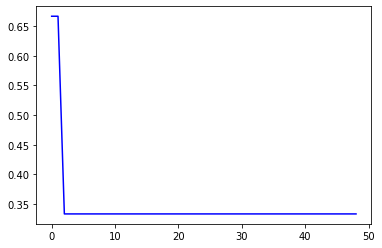

In [194]:
plt.plot(range(len(model.accuracy)), model.accuracy, '-b')

## Question 2: Spam Data

##### (a) Try to play with the parametersinteraction.depth(J),shrinkage(ν),bag.fraction(η) andthe number of iterationsM.  Report the best test errors you are able to obtain, together with thecorrespondingJ, ν, ηandM.

In [75]:
X = pd.read_csv('spam.txt', sep=' ', header=None)
y = pd.read_csv('spam_ind.txt', sep=' ', header=None)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [84]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [115]:
def adaboost(depth, shrinkage=0.01, n_iters=10):

  clf = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=depth, random_state=42),
      n_estimators=n_iters,
      learning_rate=shrinkage
  )

  clf.fit(X_train_scaled, y_train)
  y_pred = clf.predict(X_test_scaled)
  print(f"Error AdaBoost with depth {depth}, shrinkage {shrinkage}, n_iters {n_iters}: ", 1 - accuracy_score(y_test, y_pred))

In [116]:
# depth=1, shrinkage=0.01, n_iters=100
adaboost(1, 0.01, 100)

Error AdaBoost with depth 1, shrinkage 0.01, n_iters 100:  0.32493483927019984


In [117]:
# depth=5, shrinkage=0.05, n_iters=200
adaboost(5, 0.05, 200)

Error AdaBoost with depth 5, shrinkage 0.05, n_iters 200:  0.4005212858384014


In [118]:
# dept=10, shrinkage=0.1, n_iters=100
adaboost(10, 0.1, 100)

Error AdaBoost with depth 10, shrinkage 0.1, n_iters 100:  0.38575152041702865


In [119]:
# depth=1, shrinkage=0.001, n_iters=200
adaboost(1, 0.001, 200)

Error AdaBoost with depth 1, shrinkage 0.001, n_iters 200:  0.32319721980886185


##### (b) Logistic, SVM, AdaBoost

In [120]:
log_reg = LogisticRegression(random_state=42)
svc = SVC(random_state=42)

# fit logistict
log_reg.fit(X_train_scaled, y_train)
log_pred = log_reg.predict(X_test_scaled)
print("Error on Logisitic Regression: ", 1 - accuracy_score(y_test, log_pred))

# fit svm
svc.fit(X_train_scaled, y_train)
svc_pred = svc.predict(X_test_scaled)
print("Error on SVMs: ", 1 - accuracy_score(y_test, svc_pred))

# adaboost
adaboost(1, 0.001, 200)

Error on Logisitic Regression:  0.3223284100781929
Error on SVMs:  0.32927888792354476
Error AdaBoost with depth 1, shrinkage 0.001, n_iters 200:  0.32319721980886185


## Question 3 Caravan 

##### (a) Fit a boosting model to the training set withPurchase as the response and the other variables aspredictors.  Use 1,000 trees, and a shrinkage value of 0.01.  Which predictors appear to be the most important?

In [121]:
caravan = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Caravan.csv')

In [125]:
caravan.head()

,Unnamed: 0,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,MFALLEEN,MFGEKIND,MFWEKIND,MOPLHOOG,MOPLMIDD,MOPLLAAG,MBERHOOG,MBERZELF,MBERBOER,MBERMIDD,MBERARBG,MBERARBO,MSKA,MSKB1,MSKB2,MSKC,MSKD,MHHUUR,MHKOOP,MAUT1,MAUT2,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,...,PPERSAUT,PBESAUT,PMOTSCO,PVRAAUT,PAANHANG,PTRACTOR,PWERKT,PBROM,PLEVEN,PPERSONG,PGEZONG,PWAOREG,PBRAND,PZEILPL,PPLEZIER,PFIETS,PINBOED,PBYSTAND,AWAPART,AWABEDR,AWALAND,APERSAUT,ABESAUT,AMOTSCO,AVRAAUT,AAANHANG,ATRACTOR,AWERKT,ABROM,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,1,33,1,3,2,8,0,5,1,3,7,0,2,1,2,6,1,2,7,1,0,1,2,5,2,1,1,2,6,1,1,8,8,0,1,8,1,0,4,5,...,6,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
1,2,37,1,2,2,8,1,4,1,4,6,2,2,0,4,5,0,5,4,0,0,0,5,0,4,0,2,3,5,0,2,7,7,1,2,6,3,2,0,5,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
2,3,37,1,2,2,8,0,4,2,4,3,2,4,4,4,2,0,5,4,0,0,0,7,0,2,0,5,0,4,0,7,2,7,0,2,9,0,4,5,0,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
3,4,9,1,3,3,3,2,3,2,4,5,2,2,2,3,4,3,4,2,4,0,0,3,1,2,3,2,1,4,0,5,4,9,0,0,7,2,1,5,3,...,6,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No
4,5,40,1,4,2,10,1,4,1,4,7,1,2,2,4,4,5,4,0,0,5,4,0,0,0,9,0,0,0,0,4,5,6,2,1,5,4,0,0,9,...,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,No


In [132]:
X = caravan.iloc[:, 1:-1]
y = caravan.iloc[:, -1]

X_train = X.iloc[:1000, :]
X_test = X.iloc[1000:, :]
y_train = y.iloc[:1000]
y_test = y.iloc[1000:]

In [133]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1000, 85), (4822, 85), (1000,), (4822,))

In [134]:
# preprocessing
scaler = StandardScaler()
encoder = LabelEncoder()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [135]:
X_train_scaled.shape, X_test_scaled.shape, y_train_encoded.shape, y_test_encoded.shape

((1000, 85), (4822, 85), (1000,), (4822,))

In [165]:
clf = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=100, random_state=42),
      learning_rate=0.01
  )
clf.fit(X_train_scaled, y_train_encoded)
y_pred = clf.predict(X_train_scaled)
print(f"Training Error AdaBoost with depth 100, shrinkage 0.01: ", 1 - accuracy_score(y_train_encoded, y_pred))
print("Most important predictor: ", X.columns[np.argmax(clf.feature_importances_)])

Training Error AdaBoost with depth 100, shrinkage 0.01:  0.0010000000000000009
Most important predictor:  MINK3045


##### (b) Predict response on the test data

In [166]:
clf = AdaBoostClassifier(
      DecisionTreeClassifier(max_depth=100, random_state=42),
      learning_rate=0.01
  )
clf.fit(X_train_scaled, y_train_encoded)
y_pred = clf.predict(X_test_scaled)
print(f"Test Error AdaBoost with depth 100, shrinkage 0.01: ", 1 - accuracy_score(y_test_encoded, y_pred))

Test Error AdaBoost with depth 100, shrinkage 0.01:  0.10058067192036502


In [173]:
y_pred_prob = clf.predict_proba(X_test_scaled)

purchase_ratio = 0.2
y_pred_20 = y_pred_prob[:, 1] > purchase_ratio

In [177]:
print("Fraction of people predicted to make a purchase if probability of purchase is > 20%: ", y_pred_20.sum())

Fraction of people predicted to make a purchase if probability of purchase is > 20%:  277


##### (c) Logistic Regression

In [181]:
print("-"*100)
print("\t\t\tLOGISTIC REGRESSION")
print("-"*100)

log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train_scaled, y_train_encoded)

y_pred = log_reg.predict(X_train_scaled)
print("Training error: ",  1 - accuracy_score(y_train_encoded, y_pred))

y_pred = log_reg.predict(X_test_scaled)
print("Testing error: ",  1 - accuracy_score(y_test_encoded, y_pred))

y_pred_prob = log_reg.predict_proba(X_test_scaled)

purchase_ratio = 0.2
y_pred_20 = y_pred_prob[:, 1] > purchase_ratio

print("Fraction of people predicted to make a purchase if probability of purchase is > 20%: ", y_pred_20.sum())

----------------------------------------------------------------------------------------------------
			LOGISTIC REGRESSION
----------------------------------------------------------------------------------------------------
Training error:  0.05700000000000005
Testing error:  0.06594773952716715
Fraction of people predicted to make a purchase if probability of purchase is > 20%:  290


Logistic Regression performs slightly better on the test set. 